In this project, we present the implementation of a U-Net architecture for semantic segmentation of cell images. The U-Net model is a popular choice for image segmentation tasks due to its ability to capture fine details and handle various object classes. Our goal is to segment cell images into three classes: Background, Cell Body, and Cell Kernel. We have implemented the U-Net architecture and designed a training pipeline to achieve this segmentation task.

# Imports

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import matplotlib.pyplot as plt

# U-Net Model

In [2]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.channels_list = [64, 128, 256, 512]
        self.layers = len(self.channels_list)

        # Contracting Part
        self.contracting_conv_blocks = nn.ModuleList()
        self.max_pooling_blocks = nn.ModuleList()
        for channels in self.channels_list:
            self.contracting_conv_blocks.append(self.conv_block(in_channels, channels))
            self.max_pooling_blocks.append(nn.MaxPool2d(2))
            in_channels = channels

        # Connecting Part
        self.connect = self.conv_block(
            self.channels_list[-1], 2 * self.channels_list[-1]
        )

        # Expansive Part
        in_channels = 1024
        self.expansive_conv_blocks = nn.ModuleList()
        self.up_conv_blocks = nn.ModuleList()
        for channels in reversed(self.channels_list):
            self.expansive_conv_blocks.append(self.conv_block(in_channels, channels))
            self.up_conv_blocks.append(
                nn.ConvTranspose2d(in_channels, channels, 2, stride=2)
            )
            in_channels = channels

        # Final Part
        self.final = nn.Conv2d(self.channels_list[0], out_channels, 1, padding=0)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(),
        )

    def center_crop(self, x, crop_h, crop_w):
        h, w = x.shape[2], x.shape[3]
        y1 = (h - crop_h) // 2
        y2 = y1 + crop_h
        x1 = (w - crop_w) // 2
        x2 = x1 + crop_w
        return x[:, :, y1 : y2, x1 : x2]

    def forward(self, x):
        # Contracting Part
        encoder_outputs = []
        for layer in range(self.layers):
            conv_block = self.contracting_conv_blocks[layer]
            x = conv_block(x)
            encoder_outputs.append(x)
            max_pool = self.max_pooling_blocks[layer]
            x = max_pool(x)

        # Connecting Part
        x = self.connect(x)

        # Expansive Part
        for reversed_layer in reversed(range(self.layers)):
            layer = self.layers - reversed_layer - 1
            up_conv_block = self.up_conv_blocks[layer]
            x = up_conv_block(x)
            # Concatenate with the corresponding feature map
            # x = torch.cat([x, self.center_crop(encoder_outputs[reversed_layer], x.shape[2], x.shape[3])], dim=1)
            # Since padding = 1 no need for cropping.
            x = torch.cat([x, encoder_outputs[reversed_layer]], dim=1)

            conv_block = self.expansive_conv_blocks[layer]
            x = conv_block(x)

        # Final Part
        x = self.final(x)
        return x


# Create a U-Net model with 1 input channel and 3 output channels for segmentation
model = UNet(in_channels=1, out_channels=3)
print(model)


UNet(
  (contracting_conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (max_pooling_blocks): ModuleList(
    (0-3): 4 x MaxPool2d(kernel_siz

# Test input and output size

In [3]:
# Set the model to evaluation mode
model.eval()

# Load and preprocess your input image
image_path = './Datasets/Dataset 1/data/BMMC_1.tif'
image = Image.open(image_path).convert('L')  # Convert to grayscale
transform = transforms.Compose([transforms.ToTensor()])
input_image = transform(image).unsqueeze(0)  # Add a batch dimension
print("Input shape:", input_image.shape)

# Forward pass through the model
with torch.no_grad():
    output = model(input_image)

print("Output shape:", output.shape)

Input shape: torch.Size([1, 1, 1024, 1024])
Output shape: torch.Size([1, 3, 1024, 1024])


In the preceding code, we have defined the architecture of the U-Net model specifically tailored for the segmentation of cell images. The model is constructed with a contracting part to extract features and a corresponding expansive part to refine the segmentation masks. The connecting part serves as a bridge between these two parts, facilitating the flow of information across different scales.

Our U-Net model is designed to work with cell images and output masks for three classes: Background, Cell Body, and Cell Kernel. It is worth noting that the model architecture has been implemented with an awareness of potential discrepancies in input and output sizes, which can arise due to zero padding in convolutional layers. The model is now ready for training with labeled data, enabling it to learn and improve its segmentation capabilities.

To train the U-Net model for image segmentation with three classes (Background, Cell Body, Cell Kernel), we'll need to define a dataset, a loss function, and an optimizer.

# Load data and train the model

In [4]:
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.image_files[idx] + "_segmentation.tifnomalized.tif")

        image = Image.open(image_path).convert('L')  # Convert to grayscale

        # Open the mask image and convert it to an integer tensor
        mask = Image.open(mask_path)
        mask = mask.convert('L')  # Convert to grayscale
        mask = np.array(mask) # Convert the PIL image to a NumPy array

        # Convert the NumPy array to a PyTorch tensor with integer type
        mask = torch.from_numpy(mask).to(torch.int64)

        # Create a new tensor with the remapped values
        mask = (mask == 85) * 0 + (mask == 170) * 1 + (mask == 255) * 2

        if self.transform:
            image = self.transform(image)

        return image, mask

# Define data directories
image_dir = './Datasets/Dataset/data'
mask_dir = './Datasets/Dataset/masks'

# Define a transform to convert images and masks to tensors
data_transform = transforms.Compose([transforms.ToTensor()])

# Create a custom dataset
dataset = CustomDataset(image_dir, mask_dir, transform=data_transform)

# Create a dataloader
batch_size = 1  # Adjust as needed
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define a loss function (e.g., cross-entropy) and an optimizer (e.g., Adam)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
num_epochs = 100  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, masks in dataloader:
        optimizer.zero_grad()

        inputs, masks = inputs.to(device), masks.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, masks)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # print(f"Epoch [{epoch + 1}/{num_epochs}] Current Loss: {loss.item()}")

        running_loss += loss.item()

    # print()
    print(f"Epoch [{epoch + 1}/{num_epochs}] Average Loss: {running_loss / len(dataloader)}")
    # print()
    
print("Training finished")

# Save the trained model
torch.save(model.state_dict(), "unet_segmentation_model.pth")

Epoch [1/100] Average Loss: 795982.6716994382
Epoch [2/100] Average Loss: 701531.6258339186
Epoch [3/100] Average Loss: 693160.1145540731
Epoch [4/100] Average Loss: 692145.3861481742
Epoch [5/100] Average Loss: 691279.52587342
Epoch [6/100] Average Loss: 693181.7744689255
Epoch [7/100] Average Loss: 692591.7722524579
Epoch [8/100] Average Loss: 686843.5547313904
Epoch [9/100] Average Loss: 691065.4094101123
Epoch [10/100] Average Loss: 689321.4153792135
Epoch [11/100] Average Loss: 689769.0556530899
Epoch [12/100] Average Loss: 686399.4590941011
Epoch [13/100] Average Loss: 693620.895891854
Epoch [14/100] Average Loss: 689522.3407654495
Epoch [15/100] Average Loss: 689011.376755618
Epoch [16/100] Average Loss: 688126.2805477529
Epoch [17/100] Average Loss: 645563.3537789678
Epoch [18/100] Average Loss: 585829.0592959971
Epoch [19/100] Average Loss: 565682.5211332514
Epoch [20/100] Average Loss: 558583.4161253511
Epoch [21/100] Average Loss: 561363.129389045
Epoch [22/100] Average Loss

# Create and save sample segmentation outputs

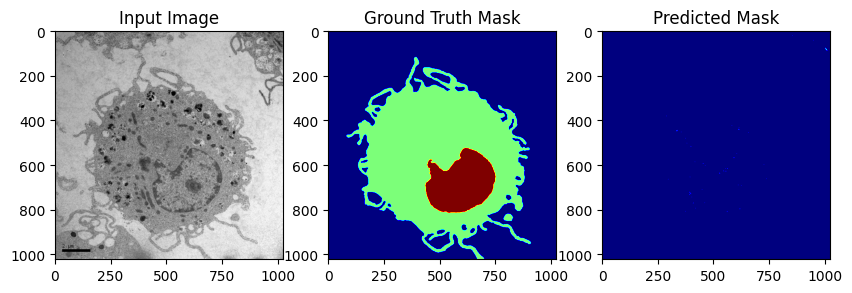

NameError: name 'jaccard_score' is not defined

In [ ]:
model.eval()

# Lists to store evaluation results for each sample
iou_scores = []
dice_scores = []
accuracy_scores = []

# Select a few images from the evaluation dataset
num_samples_to_visualize = 3
visualize_dataloader = DataLoader(dataset, batch_size=num_samples_to_visualize, shuffle=True)

for inputs, masks in visualize_dataloader:
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        # Assuming outputs are class probabilities, you can obtain the predicted class
        predicted_masks = outputs.argmax(dim=1).cpu().numpy()

        for i in range(num_samples_to_visualize):
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(inputs[i][0].cpu().numpy(), cmap='gray')

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth Mask")
            plt.imshow(masks[i].numpy(), cmap='jet')

            plt.subplot(1, 3, 3)
            plt.title("Predicted Mask")
            plt.imshow(predicted_masks[i], cmap='jet')

            plt.show()

            # Calculate and store evaluation metrics for each sample
            iou = jaccard_score(masks[i].numpy().flatten(), predicted_masks[i].flatten())
            dice = f1_score(masks[i].numpy().flatten(), predicted_masks[i].flatten())
            accuracy = accuracy_score(masks[i].numpy().flatten(), predicted_masks[i].flatten())

            iou_scores.append(iou)
            dice_scores.append(dice)
            accuracy_scores.append(accuracy)

# Calculate and print average metrics
average_iou = sum(iou_scores) / len(iou_scores)
average_dice = sum(dice_scores) / len(dice_scores)
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)

print(f"Average IoU (Jaccard Index): {average_iou}")
print(f"Average Dice Coefficient: {average_dice}")
print(f"Average Accuracy: {average_accuracy}")

print("Evaluation and Testing Finished")
